<a href="https://colab.research.google.com/github/DenisVasil/Modern_ML/blob/main/KerasCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade keras-cv tensorflow

In [ ]:
!pip install --upgrade keras

In [ ]:
import tensorflow as tf
import keras_cv
import tensorflow_datasets as tfds
import keras

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
classifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

100%|██████████| 2.80k/2.80k [00:00<00:00, 1.94MB/s]
100%|██████████| 28.0M/28.0M [00:03<00:00, 9.13MB/s]


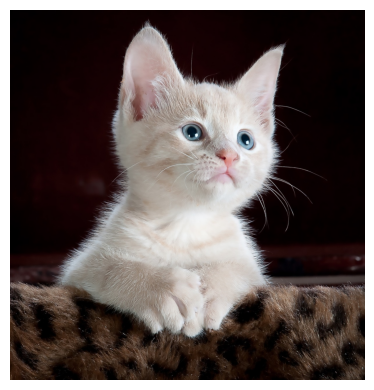

In [ ]:
import numpy as np

image = keras.utils.load_img("/content/cat-551554_1280.jpg")
image = np.array(image)
keras_cv.visualization.plot_image_gallery(
    np.array([image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

In [ ]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


In [ ]:
top_classes = predictions[0].argsort(axis=-1)

In [ ]:
import json

classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

In [ ]:
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)

Top two classes are: ['weasel', 'porcupine, hedgehog']


#Working with pre-trained classifier

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


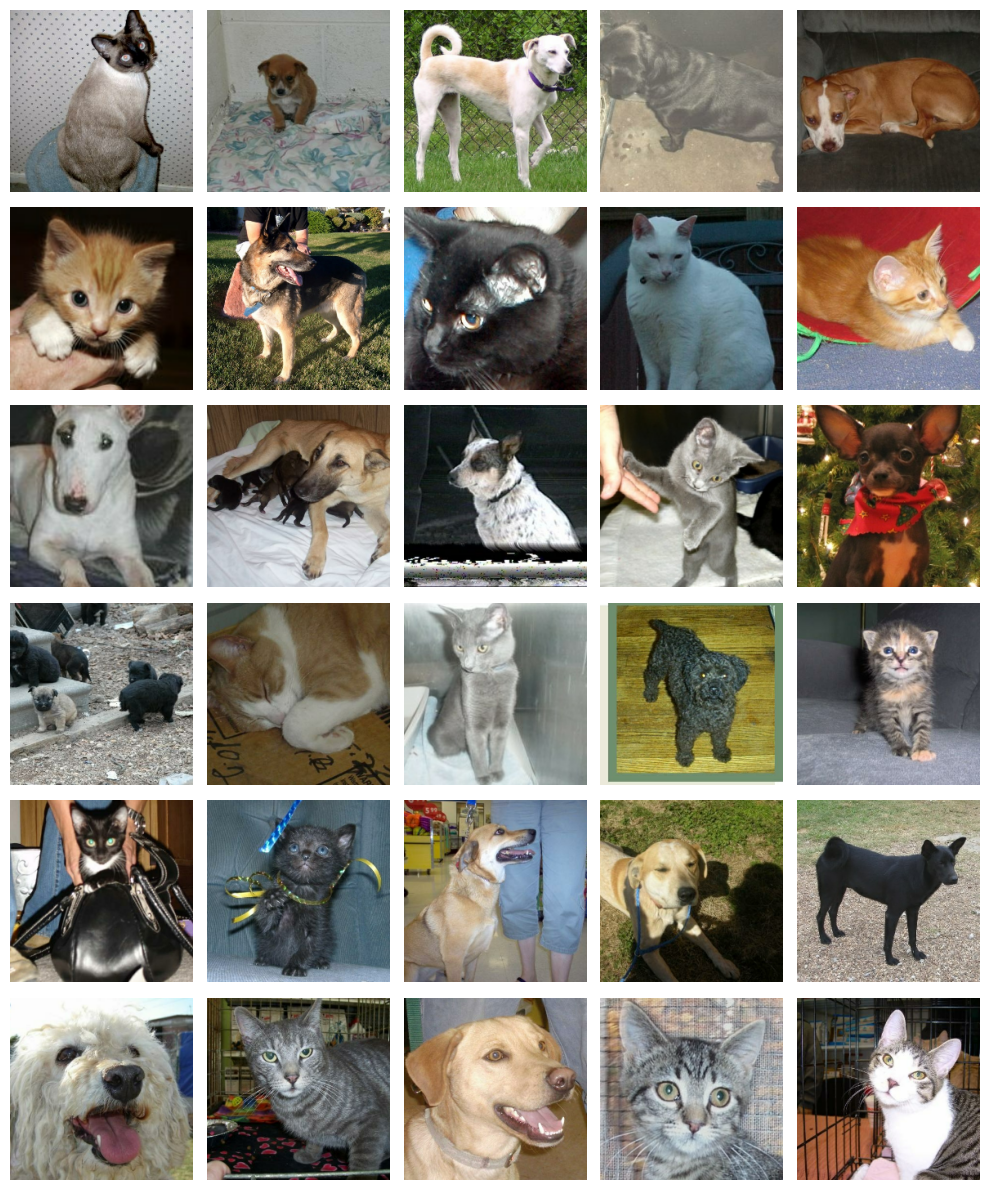

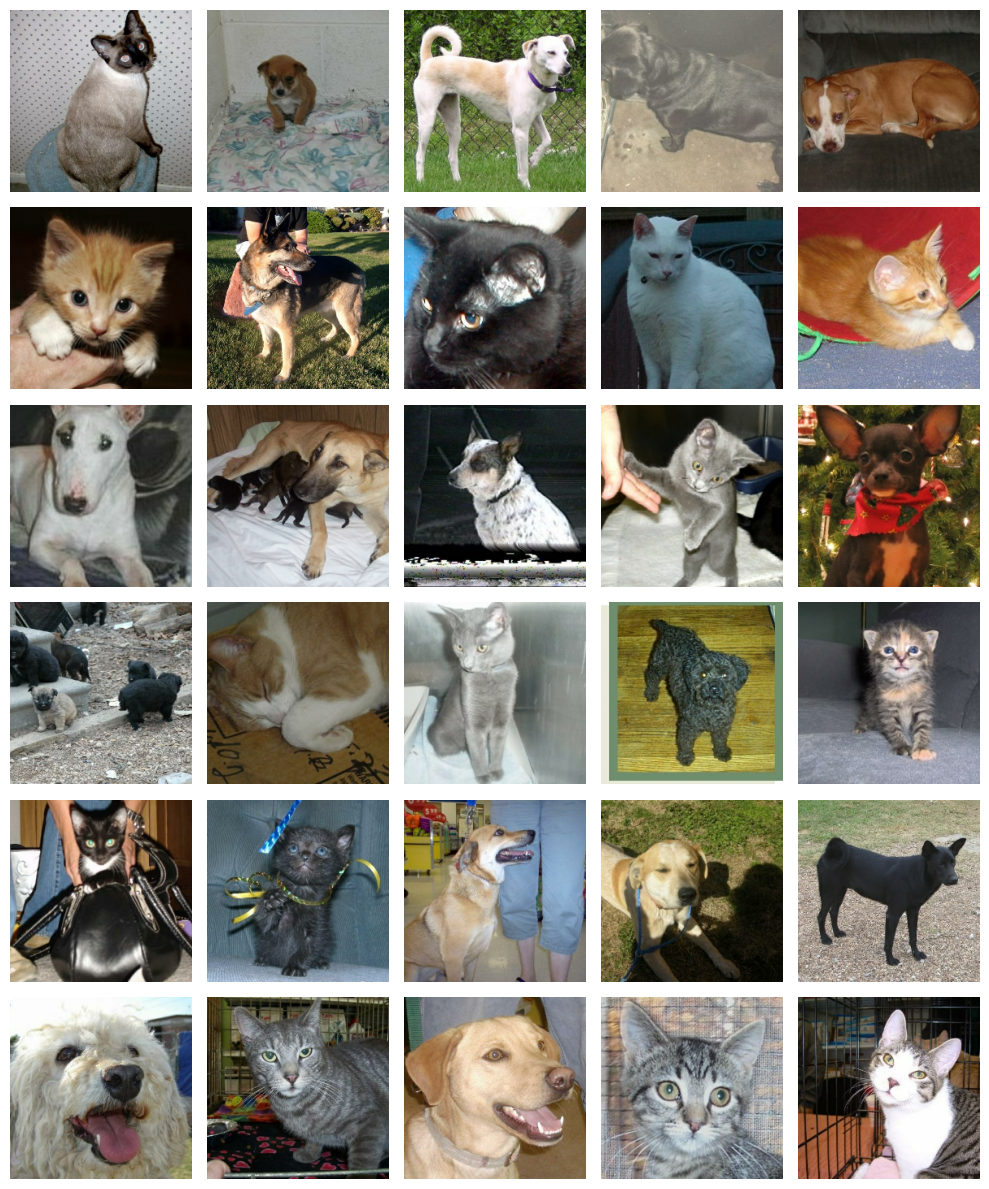

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [ ]:
from keras import losses
from keras import optimizers

model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

100%|██████████| 1.79k/1.79k [00:00<00:00, 1.71MB/s]
100%|██████████| 23.1M/23.1M [00:02<00:00, 8.36MB/s]


In [ ]:
model.fit(train_dataset)

727/727 ━━━━━━━━━━━━━━━━━━━━ 216s 186ms/step - accuracy: 0.9063 - loss: 0.3468


In [ ]:
predictions = model.predict(np.expand_dims(image, axis=0))

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Top class is: cat


# Image Augmentation

In [17]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv

In [19]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()
data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
val_steps_per_epoch = dataset_info.splits["test"].num_examples // BATCH_SIZE

In [20]:
# keras_cv.layers.CutMix and keras_cv.layers.MixUp expects targets to be one-hot encoded.

IMAGE_SIZE = (224, 224)
num_classes = dataset_info.features["label"].num_classes


def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


def load_dataset(split="train"):
    dataset = data[split]
    return prepare_dataset(dataset, split)


train_dataset = load_dataset()


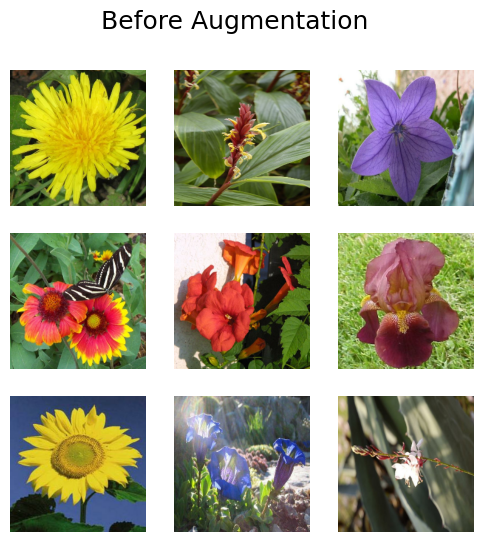

In [21]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

In [22]:
rand_augment = keras_cv.layers.RandAugment(
    value_range = (0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)

In [23]:
def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

In [24]:
train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

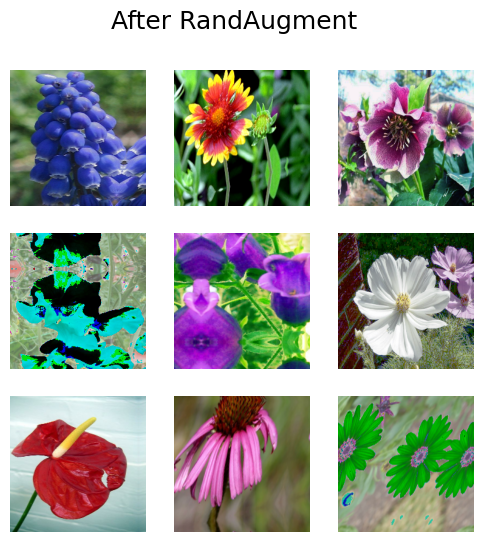

In [25]:
visualize_dataset(train_dataset, title="After RandAugment")

In [26]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()

In [27]:
def cut_mix_and_mix_up(samples):
  samples = cut_mix(samples, training=True)
  samples = mix_up(samples, training=True)
  return samples

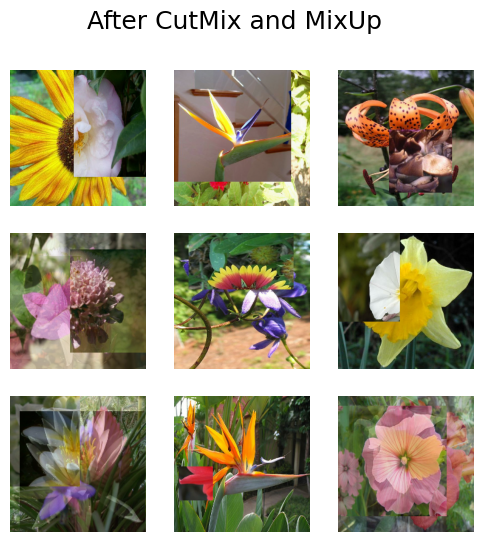

In [28]:
train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title="After CutMix and MixUp")

# Custoising the pipeline

In [29]:
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.75, magnitude_stddev=0.3
)

In [30]:
layers = [
    layer for layer in layers if not isinstance(layer, keras_cv.layers.RandomRotation)
]

In [31]:
layers = layers + [keras_cv.layers.GridMask()]

In [32]:
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers, augmentations_per_image=3
)


def apply_pipeline(inputs):
    inputs["images"] = pipeline(inputs["images"])
    return inputs

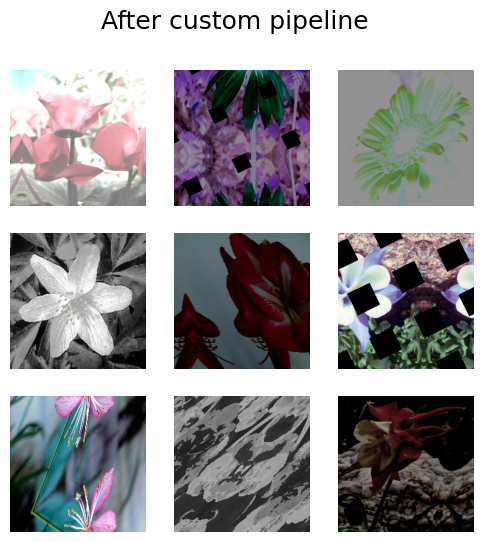

In [33]:
train_dataset = load_dataset().map(apply_pipeline, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After custom pipeline")

In [36]:
# This pipeline applies either GrayScale or GridMask:
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=[keras_cv.layers.GridMask(), keras_cv.layers.Grayscale(output_channels=3)],
    augmentations_per_image=1,
)

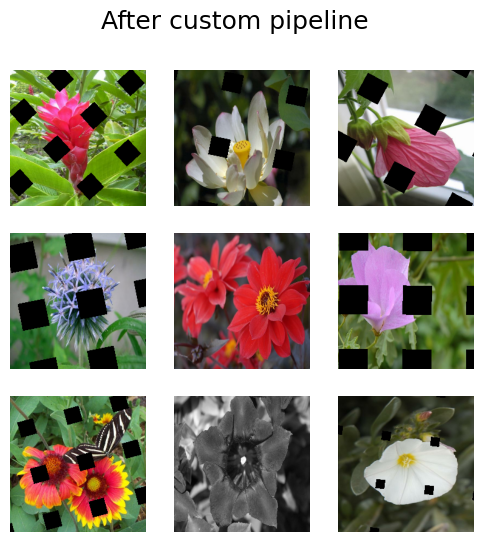

In [37]:
train_dataset = load_dataset().map(apply_pipeline, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After custom pipeline")

# Flower dataset with ResNet50 image classifier

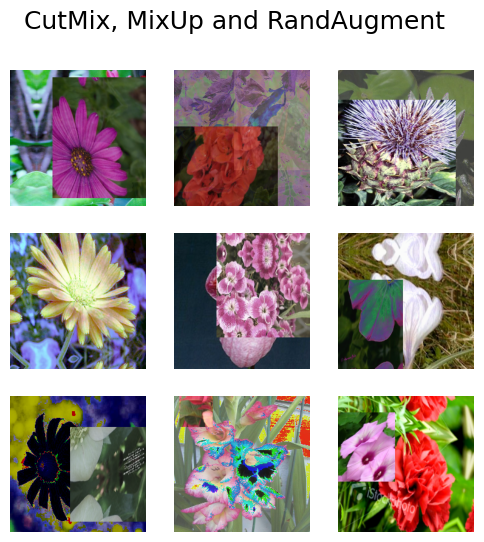

In [38]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels


train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, "CutMix, MixUp and RandAugment")

In [39]:
train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

test_dataset = load_dataset(split="test")
test_dataset = test_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

In [41]:
input_shape = IMAGE_SIZE + (3,)

model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_s", num_classes=num_classes
)

100%|██████████| 1.78k/1.78k [00:00<00:00, 2.44MB/s]


In [42]:
model.compile(
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=keras.optimizers.SGD(momentum=0.9),
        metrics=["accuracy"],
    )

In [43]:
model.fit(
    train_dataset,
    epochs=1,
    validation_data=test_dataset,
)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1948s 59s/step - accuracy: 0.0088 - loss: 4.7386 - val_accuracy: 0.0068 - val_loss: 31.3417
